## To do

1. find some way to prevent loss when converting from mel to png.
    convert to black and white, find the loudest portion, get the index of that window? 

2. Noisey to clean speech conversion?

3. re-train algorightm with new spectrograms

## Notes

Frequency: The speed of the vibration. Measured as the number of wave cycles in a second.

Hz: The measure of the frequency. 10 hz = 10 wave cycles per second.

Mel: similar to Hz the mel scale is a quasi logarithmic scale for measuring frequency

Amplitude: The size of the vibration, determines how loud the sound is

dB: measure of amplitude. On a logarithmic scale

Hop length: How much time you can advance the analysis point of origin from frame to frame. Essentially the overlap between frame. Lower hop length = more overlap = smoother results, but it is computationally more expensive

fft: fast fourier transformatin. Microphones measure air pressure. Pressure is a combination of pure frequencies. The fourier transformation is the process of decomposing pressure into its pure frequency parts. 

In [1]:
import librosa
import librosa.display

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from IPython.display import Audio

import os
import shutil

import skimage
import skimage.io

from PIL import Image

# Explanation

In [368]:
# load the audio sample, y is a numpy array representing the audio
# and sr is the sample rate, or the number of samples per second of audio
# by default audio is mixed to mono and resampled at 22050 Hz
y, sr = librosa.load('../Data/ryerson/03-01-01-01-01-01-01.wav')

# trim the silent edges
sample, _ = librosa.effects.trim(y)
# play the audio
Audio(data=sample, rate=sr)

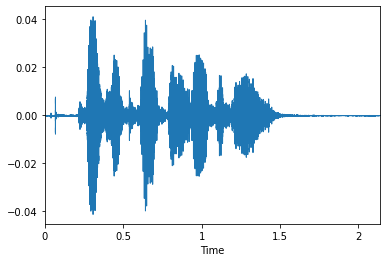

In [134]:
# show a waveplot
librosa.display.waveplot(sample, sr=sr);

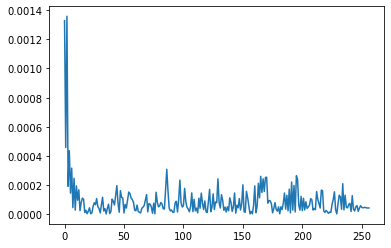

In [135]:
# stft = short-time fourrier transformation. Fourier transformation is a function
# that takes time as the input and outputs frequency. 
# n_fft is the window legth, recommended is 512 for speech.
n_fft = 512
D = np.abs(librosa.stft(sample[:n_fft], n_fft=n_fft, hop_length=n_fft+1))
plt.plot(D);

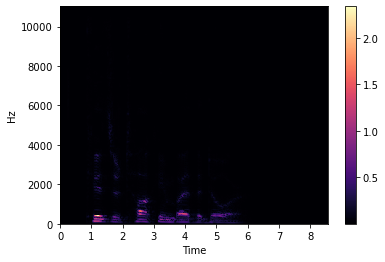

In [136]:
# standard hop length is window length/4
hop_length = 128
D = np.abs(librosa.stft(sample, n_fft=n_fft, hop_length=hop_length))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear');
plt.colorbar();

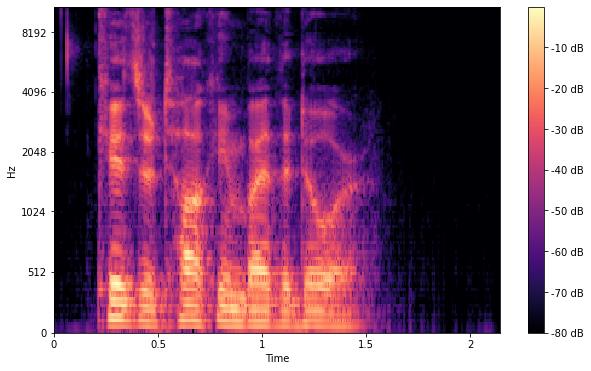

In [245]:
# n_fft is the window legth, recommended is 512 for speech.
n_fft = 512

# standard hop length is window length/4
hop_length = 128

# convert the audio sample to a mel spectrogram. By default it sets the number of mel bins to 128
S = librosa.feature.melspectrogram(sample, sr=sr, n_fft=n_fft, hop_length=hop_length)
# convert a power spectrogram (amplitude squared) to decibels
S_DB = librosa.power_to_db(S, ref=np.max)

# plot
plt.figure(figsize=(10, 6));
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel');
plt.colorbar(format='%+2.0f dB');

In [151]:
Audio(librosa.feature.inverse.mel_to_audio(S, sr = sr, n_fft = n_fft, hop_length = hop_length), rate = sr)

In [232]:
# convert to decibles, take the loudest frames, convert back to mel and play audio
test = librosa.db_to_power(loudest_window(S_DB), ref=1)
Audio(librosa.feature.inverse.mel_to_audio(test, sr = sr, n_fft = n_fft, hop_length = hop_length), rate = sr)

In [236]:
test = loudest_window(S)
Audio(librosa.feature.inverse.mel_to_audio(test, sr = sr, n_fft = n_fft, hop_length = hop_length), rate = sr)

In [163]:
test = librosa.db_to_power(np.asarray(im), ref=1)
Audio(librosa.feature.inverse.mel_to_audio(test, sr = sr, n_fft = n_fft, hop_length = hop_length), rate = sr)

In [ ]:
y, sr = librosa.load(wav_file)
# trim the silence at edges
sample, _ = librosa.effects.trim(y, top_db=30, ref = np.max, hop_length = 128, frame_length=512)
# use log-melspectrogram
mels = librosa.feature.melspectrogram(y=sample, sr=sr, n_mels=n_mels,
                                        n_fft=128*4, hop_length=128)
# convert mel to decibles
DB = librosa.power_to_db(mels, ref=np.max)
# Standardize by finding the loudest window or adding silence
# and rescaling
DB = standardize(DB)
    
# save the image
skimage.io.imsave(out_file, DB)

In [434]:

#mels = loudest_window(S)
y, sr = librosa.load('../Data/ryerson/03-01-01-01-01-01-01.wav')
n_fft = 512
# standard hop length is window length/4
hop_length = 128
# convert the audio sample to a mel spectrogram. By default it sets the number of mel bins to 128
#sample, _ = librosa.effects.trim(y, top_db=30, ref = np.max, hop_length = 128, frame_length=512)
S = librosa.feature.melspectrogram(y, sr=sr, n_fft=n_fft, hop_length=hop_length)

DB = librosa.power_to_db(S, ref=np.max)
DB = standardize(DB)
DB = scale_minmax(DB, 0, 255).astype(np.uint8)

skimage.io.imsave('db_example.png', DB)

im = Image.open('db_example.png')
array = np.asarray(im)

test = librosa.db_to_power(array, ref=1)
Audio(librosa.feature.inverse.mfcc_to_audio(test, sr = sr, n_fft = n_fft, hop_length = hop_length), rate = sr)

ParameterError: Audio buffer is not finite everywhere

In [532]:
#spectrogram_image('../Data/ryerson/03-01-01-01-01-01-01.wav', 'test5.png')

im = Image.open('speech-mel-00003.png')
array = np.asarray(im)
array = array
test = librosa.db_to_power(array, ref=1)
#Image.fromarray(array, mode = 'P')
Audio(librosa.feature.inverse.mel_to_audio(test, sr = sr, n_fft = 1024, hop_length = 256), rate = sr)

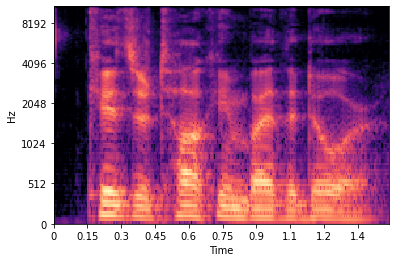

In [248]:
librosa.display.specshow(array, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')

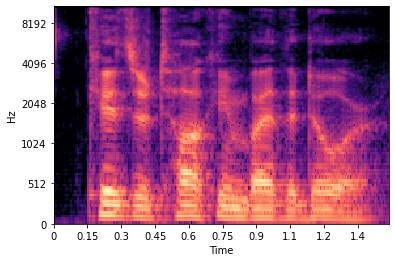

In [249]:
librosa.display.specshow(DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')

In [534]:
%%time
prep = Preprocess(n_mels = 80, hop_length = 256, win_size = 128)
im = prep.spectrogram_image(wav_file = '../Data/ryerson/03-01-01-01-01-01-01.wav', out_file = 'test.png', save = False)
prep.play_spectrogram(im)

CPU times: user 1.72 s, sys: 2.23 s, total: 3.95 s
Wall time: 1.65 s


# Functions

Process

1. open wav and get mels

2. convert mels to DB

3. Get loudest window or add silence

4. save as image

5. translate emotion

6. Open image

7. Convert to array

8. run DB to mel

9. Mel to audio

In [2]:
class Preprocess:
    def __init__(self, hop_length=128, n_mels=256, win_size=256):
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.n_fft = hop_length * 4
        self.frame_length = hop_length * 4
        self.win_size= win_size
        
    def scale_minmax(self, X, min=0, max=255):
        '''
        Scales and converts the spectrogram to a PNG
        Called by spectrogram_image()
        '''
        X_std = (X - X.min()) / (X.max() - X.min())
        X_scaled = X_std * (max - min) + min
        return X_scaled
    
    def loudest_window(self, spectrogram):
        '''
        Identifies the loudest window of a specified size within a spectrogram
        '''
        # Convert the array to a spectrogram
        array = np.asarray(spectrogram)
        # get the width of the array
        width = array.shape[1]
        # set the starting and ending of the window
        start = 0
        end = self.win_size
        arrays = []
        # move the window across the image advancing by 1 pixel.
        # append the array in the window to the list of arrays
        while end <= width:
            window = array[0:self.n_mels,start:end]
            arrays.append(window)
            start += 1
            end += 1
        # get the sum of each window in the array
        sums = [np.sum(window) for window in arrays]
        # get the index of the smallest window. This will be the loudest section
        index = sums.index(max(sums))
        # pull the loudest window from the list and return it.
        loudest = arrays[index]
        return loudest

    def add_silence(self, spectrogram):
        '''
        Adds silence to the end of a spectrogram if the spectrogram is shorter than
        the minimum window size
        '''
        # get the width of the spectrogram
        width = spectrogram.shape[1]
        # subtract the width from the minimum width to determine number of silent columns to add
        n_col = self.win_size-width
        # create silent columns
        silence = np.full((self.n_mels, n_col), 0)
        # convert the spectrogram to an array
        spect_ar = np.asarray(spectrogram)
        # add the silence to the spectrogram array
        spect_ar = np.concatenate((spect_ar, silence), axis = 1).astype(np.uint8)
        return spect_ar

    def standardize(self, spectrogram):
        '''
        Standardizes an image using the loudest_window() and add_silence() functions
        Pass spectrogram as an array
        '''
        width = spectrogram.shape[1]
        # if the width of the spectrogram is less than the minimum, add silence
        if width < self.win_size:
            spect = self.add_silence(spectrogram)
        # otherwise get the loudest window
        else:
            spect = self.loudest_window(spectrogram)
        # scale and return
        return scale_minmax(spect).astype(np.uint8)
    
    def spectrogram_image(self, wav_file, out_file = '', save = True):
        '''
        Converts a WAV file to a spectrogram and sames the image

        wav_file: The path to a WAV file as a string
        '''
        # load the audio data
        y, sr = librosa.load(wav_file)
        # trim the silence at edges
        #sample, _ = librosa.effects.trim(y, top_db=30, ref = np.max, hop_length = 128, frame_length=512)
        # use log-melspectrogram
        mels = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=self.n_mels,
                                                n_fft=self.hop_length*4, hop_length=self.hop_length)
        # convert mel to decibles
        DB = librosa.power_to_db(mels, ref=np.max)
        # Standardize by finding the loudest window or adding silence
        # and rescaling
        DB = self.standardize(DB)

        # save the image
        if save == True:
            skimage.io.imsave(out_file, DB)
        else:
            return Image.fromarray(DB, mode = 'P')
        
    def play_spectrogram(self, spectrogram, sr = 22050, n_fft = 1024, hop_length = 256):
        array = np.asarray(spectrogram)
        mels = librosa.db_to_power(array, ref=1)
        return Audio(librosa.feature.inverse.mel_to_audio(mels, sr = sr, n_fft = self.hop_length*4, hop_length = self.hop_length), rate = sr)

# Ryerson Spectrograms

In [3]:
prep = Preprocess(n_mels = 80, hop_length = 256, win_size = 128)

In [538]:
%%time
# Serial conversion
# import a list of the audio files to be converted
ryerson = pd.read_csv('ryerson_meta_sub.csv')
ryerson = ryerson['file']

# delete the old folder and create the new one
make_folder('ryerson')

# get the directory of the folders with the wav files
directory = '../Data/ryerson/'

for file in ryerson:
    # get the directory for the individual file
    wav = directory + '/' + file
    # assign a name to the output file
    out = './spectrograms/ryerson/' + file[:-4] + '.png'
    # load the audio data and sample rate
    prep.spectrogram_image(wav_file = wav, out_file = out, save=True)

CPU times: user 2min 37s, sys: 1min 53s, total: 4min 31s
Wall time: 2min 20s


In [541]:
%%time
# parallel conversion

# get all audio file names
ryerson = pd.read_csv('ryerson_meta_sub.csv')
ryerson = ryerson['file']
# create a list to file paths
files = ['../Data/ryerson/' + file for file in ryerson]
output = ['./spectrograms/ryerson/' + file[:-4] + '.png' for file in ryerson]
args = tuple(zip(files, output))

make_folder('ryerson')

if __name__=='__main__':
    with multiprocessing.Pool(processes = multiprocessing.cpu_count()-1) as pool:
        pool.starmap(prep.spectrogram_image, args)

CPU times: user 111 ms, sys: 161 ms, total: 272 ms
Wall time: 52.8 s


# Crema-d Spectrograms

In [542]:
# Crema-D is not as complete as the ryerson data so it needs to be subset to
# only samples that are complete (recordings for neutral and all emotions)

# import the meta data
cremad = pd.read_csv('cremad_meta_sub.csv')

# Make a list of all the neutral files, then a list of all possible emotional versions
neutral = cremad[cremad['emotion'] == 'neutral']['file']
happy = [file[0:9] + 'HAP' + file[12:] for file in neutral]
sad = [file[0:9] + 'SAD' + file[12:] for file in neutral]
angry = [file[0:9] + 'ANG' + file[12:] for file in neutral]
fearful = [file[0:9] + 'FEA' + file[12:] for file in neutral]
disgust = [file[0:9] + 'DIS' + file[12:] for file in neutral]

# Create a dictionary then create a data frame
d = {
    'neutral': neutral,
    'happy': happy,
    'sad': sad,
    'angry': angry,
    'fearful': fearful,
    'disgust': disgust
}
cremad = pd.DataFrame(d, index = None).reset_index().iloc[:,1:]

# get a list of all the possible files
files = cremad.values.flatten()
# get a list of all the spectrograms
wavs = os.listdir('../Data/crema-d/AudioWAV')

# identify possible files that are missing from actual files
missing = list(set(files) - set(wavs))

# replace missing files with missing values in the df
for file in missing:
    cremad.replace(file, np.nan, inplace = True)
    
# drop incomplete rows 
cremad.dropna(inplace = True)
cremad.reset_index(drop = True)
# return a list of all files that will be used
cremad_files = cremad.values.flatten()

In [32]:
%%time
# serial conversion

try:
    shutil.rmtree('./spectrograms/crema-d')
    os.mkdir('./spectrograms/crema-d')
except OSError:
    os.mkdir('./spectrograms/crema-d')

# get the directory of the folders with the wav files
directory = '../Data/crema-d/AudioWAV'

# loop through files identified as part of a complete set
for file in cremad_files:
    # get the directory for the individual file
    wav = directory + '/' + file
    # assign a name to the output file
    out = './spectrograms/crema-d/' + file[:-4] + '.png'
    # load the audio data and sample rate
    spectrogram_image(wav_file = wav, out_file = out, hop_length = 128)

<ipython-input-7-a5be3a6796b9>:4: RuntimeWarning: invalid value encountered in true_divide
  X_std = (X - X.min()) / (X.max() - X.min())
<ipython-input-7-a5be3a6796b9>:27: UserWarning: ./spectrograms/crema-d/1076_MTI_SAD_XX.png is a low contrast image
  skimage.io.imsave(out_file, img)


CPU times: user 32min 15s, sys: 1h 4min 30s, total: 1h 36min 45s
Wall time: 14min 42s


In [546]:
%%time
# parallel conversion
files = ['../Data/crema-d/AudioWAV/' + file for file in cremad_files]
output = ['./spectrograms/crema-d/' + file[:-4] + '.png' for file in cremad_files]
args = tuple(zip(files, output))

make_folder('crema-d')

if __name__=='__main__':
    with multiprocessing.Pool(processes = multiprocessing.cpu_count()-1) as pool:
        pool.starmap(prep.spectrogram_image, args)

<ipython-input-398-2d687fad6d38>:6: RuntimeWarning: invalid value encountered in true_divide
  X_std = (X - X.min()) / (X.max() - X.min())
<ipython-input-544-47040371c061>:98: UserWarning: ./spectrograms/crema-d/1076_MTI_SAD_XX.png is a low contrast image
  skimage.io.imsave(out_file, DB)


CPU times: user 200 ms, sys: 323 ms, total: 523 ms
Wall time: 8min 20s


# Standardizing images

### Serial

In [110]:
%%time
# folder containing the spectrograms
path = './spectrograms/ryerson/'
# get a list of images
spectrograms = os.listdir(path)
# loop through the list
for png in spectrograms:
    standardize(path + png)

CPU times: user 1.56 s, sys: 91.1 ms, total: 1.65 s
Wall time: 1.65 s


In [109]:
%%time
# folder containing the spectrograms
path = './spectrograms/crema-d/'
# get a list of images
spectrograms = os.listdir(path)
# loop through the list
for png in spectrograms:
    standardize(path + png)

CPU times: user 26.6 s, sys: 1.39 s, total: 28 s
Wall time: 28.4 s


### Parallel

In [71]:
%%time
files = os.listdir('./spectrograms/ryerson/')
spectrograms = ['./spectrograms/ryerson/' + file for file in files]

if __name__=='__main__':
    with multiprocessing.Pool(processes = multiprocessing.cpu_count()-1) as pool:
        pool.map(standardize, spectrograms)

CPU times: user 43.8 ms, sys: 65.3 ms, total: 109 ms
Wall time: 420 ms


In [80]:
%%time
files = os.listdir('./spectrograms/crema-d/')
spectrograms = ['./spectrograms/crema-d/' + file for file in files]

if __name__=='__main__':
    with multiprocessing.Pool(processes = multiprocessing.cpu_count()-1) as pool:
        pool.map(standardize, spectrograms)

CPU times: user 82 ms, sys: 40.9 ms, total: 123 ms
Wall time: 15.3 s


# Organize data for training

### Ryerson Training data

In [547]:
# import meta data
ryerson = pd.read_csv('ryerson_meta_sub.csv')
# list of all neutral files
neutral = ryerson[ryerson['emotion'] == 'neutral']['file']
# create lists of all emotional iterations of the neutral files
happy = [file[0:6] + '03-02' + file[11:] for file in neutral]
sad = [file[0:6] + '04-02' + file[11:] for file in neutral]
angry = [file[0:6] + '05-02' + file[11:] for file in neutral]
fearful = [file[0:6] + '06-02' + file[11:] for file in neutral]
disgust = [file[0:6] + '07-02' + file[11:] for file in neutral]

# create a data frame of the lists
d = {
    'neutral': neutral,
    'happy': happy,
    'sad': sad,
    'angry': angry,
    'fearful': fearful,
    'disgust': disgust
}
training = pd.DataFrame(d, index = None).reset_index(drop=True)
# replace .wav file extension with .png
training.replace('.wav', '.png', regex=True, inplace = True)

# copy all files to discrete emotion folders
for col in training.columns:
    make_folder(col)
    pngs = training[col]
    for png in pngs:
        shutil.copy('./spectrograms/ryerson/' + png, './spectrograms/'+ col + '/' + png)

### Crema-d training data

In [548]:
# use the previously created cremad df, replace .wav with .png
cremad.replace('.wav', '.png', regex=True, inplace = True)

for col in cremad.columns:
    pngs = cremad[col]
    for png in pngs:
        shutil.copy('./spectrograms/crema-d/' + png, './spectrograms/'+ col + '/' + png)

### Standardize labels of training data

In [549]:
# neutral and emotional spectrograms need the same names for training
emotions = ['neutral', 'happy', 'fearful', 'disgust', 'angry', 'sad']
for emotion in emotions:
    folder = './spectrograms/' + emotion + '/'
    files = os.listdir(folder)
    for file in files:
        # rename crema D files
        if len(file) == 19:
            rename = file[:8] + file[-4:]
            os.rename(folder + file, folder + rename)
        # rename ryerson files
        elif len(file) == 24:
            rename = file[:6] + file[12:]
            os.rename(folder + file, folder + rename)

# Train test split

In [4]:
import sklearn

def data_split(examples, labels, train_frac, random_state=None):
    ''' https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
    param data:       Data to be split
    param train_frac: Ratio of train set to whole dataset

    Randomly split dataset, based on these ratios:
        'train': train_frac
        'valid': (1-train_frac) / 2
        'test':  (1-train_frac) / 2

    Eg: passing train_frac=0.8 gives a 80% / 10% / 10% split
    '''

    assert train_frac >= 0 and train_frac <= 1, "Invalid training set fraction"

    X_train, X_tmp, Y_train, Y_tmp = sklearn.model_selection.train_test_split(
                                        examples, labels, train_size=train_frac, random_state=random_state)

    X_val, X_test, Y_val, Y_test   = sklearn.model_selection.train_test_split(
                                        X_tmp, Y_tmp, train_size=0.5, random_state=random_state)

    return X_train, X_val, X_test,  Y_train, Y_val, Y_test


In [6]:
examples = os.listdir('./spectrograms/neutral/')
labels = os.listdir('./spectrograms/angry/')

In [7]:
X_train, X_val, X_test,  Y_train, Y_val, Y_test = data_split(examples, labels, .7)

In [9]:
def make_folder(path):
    if os.path.exists(path):
        shutil.rmtree(path)
        os.makedirs(path)
    else:
        os.makedirs(path)

In [10]:
make_folder('spectrograms/pix2pix_angry/A/train/')

In [13]:
# prepare neutral training data (A)

make_folder('spectrograms/pix2pix_angry/A/train/')
for file in X_train:
    shutil.copy('./spectrograms/neutral/' + file, './spectrograms/pix2pix_angry/A/train/'+ file)
    
make_folder('spectrograms/pix2pix_angry/A/test/')
for file in X_test:
    shutil.copy('./spectrograms/neutral/' + file, './spectrograms/pix2pix_angry/A/test/'+ file)
    
make_folder('spectrograms/pix2pix_angry/A/val/')
for file in X_val:
    shutil.copy('./spectrograms/neutral/' + file, './spectrograms/pix2pix_angry/A/val/'+ file)

In [14]:
make_folder('spectrograms/pix2pix_angry/B/train/')
for file in Y_train:
    shutil.copy('./spectrograms/angry/' + file, './spectrograms/pix2pix_angry/B/train/'+ file)
    
make_folder('spectrograms/pix2pix_angry/B/test/')
for file in Y_test:
    shutil.copy('./spectrograms/angry/' + file, './spectrograms/pix2pix_angry/B/test/'+ file)
    
make_folder('spectrograms/pix2pix_angry/B/val/')
for file in Y_val:
    shutil.copy('./spectrograms/angry/' + file, './spectrograms/pix2pix_angry/B/val/'+ file)

In [16]:
# call the combine AB script to finalize training data
! python combine_A_and_B.py --fold_A './spectrograms/pix2pix_angry/A' --fold_B './spectrograms/pix2pix_angry/B' --fold_AB './spectrograms/pix2pix_angry/AB'

[fold_A] =  ./spectrograms/pix2pix_angry/A
[fold_B] =  ./spectrograms/pix2pix_angry/B
[fold_AB] =  ./spectrograms/pix2pix_angry/AB
[num_imgs] =  1000000
[use_AB] =  False
split = val, use 157/157 images
split = val, number of images = 157
split = train, use 730/730 images
split = train, number of images = 730
split = test, use 157/157 images
split = test, number of images = 157
